In [ ]:
import cv2
import os

In [ ]:
input_dir = "input"
output_dir = "otput"

In [ ]:
image_files = os.listdir(input_dir)

In [ ]:
for image_file in image_files:

    input_image = cv2.imread(os.path.join(input_dir, image_file))

    distorted_image = cv2.flip(input_image, 1) # flip horizontally
    distorted_image = cv2.GaussianBlur(distorted_image, (5, 5), 0) # apply Gaussian blur

    output_file = os.path.join(output_dir, f"distorted_{image_file}")
    cv2.imwrite(output_file, distorted_image)

In [ ]:
import numpy as np
from skimage.feature import daisy
from sklearn.neighbors import NearestNeighbors

In [ ]:

image_pair_1 = ["/content/output/distorted_1.jpg", "/content/output/distorted_2.jpg"]
image_pair_2 = ["/content/output/distorted_3.jpg", "/content/output/distorted_4.jpg"]

In [ ]:
# DAISY feature descriptor parameters
radius = 15
num_neighbors = 8
num_histograms = 8
num_orientations = 8

In [ ]:
orb = cv2.ORB_create()

for pair in [image_pair_1, image_pair_2]:
    # Read input images
    img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)

    # Detect and compute ORB keypoints and descriptors for both images
    keypoints1, desc1 = orb.detectAndCompute(img1, None)
    keypoints2, desc2 = orb.detectAndCompute(img2, None)

    # Compute DAISY descriptors for both images
    desc1 = daisy(img1, step=8, radius=radius, rings=2, histograms=num_histograms,
                  orientations=num_orientations, visualize=False)
    desc2 = daisy(img2, step=8, radius=radius, rings=2, histograms=num_histograms,
                  orientations=num_orientations, visualize=False)

    # Reshape descriptors to be 2D arrays
    desc1 = desc1.reshape(desc1.shape[0], -1)
    desc2 = desc2.reshape(desc2.shape[0], -1)

    # Find nearest neighbors between descriptors of both images
    neigh = NearestNeighbors(n_neighbors=2, algorithm='kd_tree')
    neigh.fit(desc1)
    distances, indices = neigh.kneighbors(desc2)

    # Compute affine transformation between nearest neighbors
    pts1 = np.array([kp.pt for kp in keypoints1])
    pts2 = np.array([kp.pt for kp in keypoints2])
    affine = cv2.estimateAffinePartial2D(pts2[indices[:, 0].astype(int)], pts1[indices[:, 1].astype(int)])

    # Print estimated transformation parameters
    print(f"Image pair: {pair}")
    if affine is None:
        print("No matching keypoints found.")
    else:
        print("Affine transformation parameters:")
        print(f"Rotation angle: {np.degrees(np.arctan2(affine[1][0], affine[0][0]))}")
        print(f"Translation x: {affine[0][1]}")
        print(f"Translation y: {affine[1][2]}")

Image pair: ['/content/output/distorted_1.jpg', '/content/output/distorted_2.jpg']
Affine transformation parameters:
Rotation angle: [180. 180.   0.]
Translation x: [  0.54740626  -0.29527186 248.17993909]
Translation y: [0]
Image pair: ['/content/output/distorted_3.jpg', '/content/output/distorted_4.jpg']
Affine transformation parameters:
Rotation angle: [81.48993373 94.08201296  0.38588518]
Translation x: [ 0.07136535  0.14963062 26.45234182]
Translation y: [1]


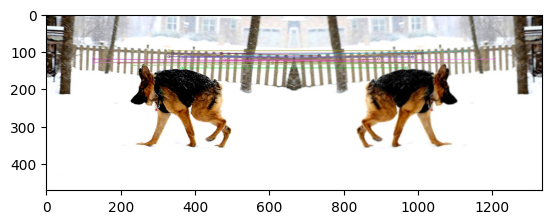

In [ ]:
def match_images(img1, img2):
    # Convert images to grayscale
    # Initialize SIFT feature detector and descriptor extractor
    # Detect keypoints and compute descriptors for both images
    # Match keypoints using brute-force matching
    # Sort matches by distance
    # Convert images from BGR to RGB format for plotting
    # Draw matched keypoints as a plot

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, desc1 = sift.detectAndCompute(gray1, None)
    kp2, desc2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.match(desc1, desc2)

    matches = sorted(matches, key=lambda x: x.distance)

    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    img_matches = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches)
    plt.show()

img1 = cv2.imread("/content/input/2.jpg")
img2 = cv2.imread("/content/output/distorted_2.jpg")
match_images(img1, img2)